# Geographical and Practice Data

## Set up, Data loading

In [1]:
##Initial Set Up

!pip install pandas
!pip install matplotlib
!pip install requests
!pip install "notebook>=5.3" "ipywidgets>=7.5"
!pip install plotly

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import requests
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'browser'

import data

In [2]:
M2020 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\EPD_202004.csv')

M2021 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\EPD_202104.csv')

##Import Population Data by Practice

pop_gp_2020 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\gp_pop.csv')

pop_gp_2021 = pd.read_csv (r'C:\Users\nickw\OneDrive\Documents\Python Scripts\Test\Test\GP_Pop_2021.csv')

##Import Geojson

r = requests.get('https://raw.githubusercontent.com/missinglink/uk-postcode-polygons/master/geojson/M.geojson')

Manchester_Map = r.json()

## OPTIONAL BNF CHAPTER PLUS Codes 

Use this section with BNF_CHAPTER_PLUS_CODE to view regional data based on specific catergories (prompted by Peters research I have run it on a "02: Cardiovascular System" as one of the areas of intrest and have put choropleth maps in folder)   

In [ ]:
BNF_Code = ""

M2020 = M2020[M2020['BNF_CHAPTER_PLUS_CODE']== BNF_Code]

M2021 = M2021[M2021['BNF_CHAPTER_PLUS_CODE']== BNF_Code]

## Clean, Link and Test Data

In [3]:
##Split the postcode

M2020[['Postcode_Region', 'Postcode_Detail']] = M2020.POSTCODE.str.split(" ", expand=True)

##Group by Practice sum

M2020 = M2020.groupby(['PRACTICE_CODE', 'POSTCODE', 'PRACTICE_NAME', 'Postcode_Region']).sum().reset_index()

## Link with Popualtion Data for GP Practices

M2020 = pd.merge(M2020,pop_gp_2020 ,on='PRACTICE_CODE',how='left')

M2020 ['Cost_Capita']= M2020.ACTUAL_COST/M2020.Population

##Test all rows where null 

TestM2020= M2020[M2020.isna().any(axis=1)]

print(TestM2020['PRACTICE_NAME'])

79                COMMUNITY PAEDIATRICIANS
80      VIOLENT PATIENT ENHANCED SERVICE 1
81                                    PCEC
82                     BUCCLEUCH LODGE ICF
84     GORTON PARKS INTERMEDIATE CARE UNIT
86       NURSING HOME PROJECT TEAM (SOUTH)
88           GTD HEALTHCARE GP SERVICE OOH
92        TURNING POINT SMITHFIELD SERVICE
93              CONTINENCE SERVICE PROJECT
94                       NMPS TRAFFORD LCO
95                PAHNT COMMUNITY SERVICES
96        MFT CHILDRENS COMMUNITY SERVICES
97            MFT ADULT COMMUNITY SERVICES
98                 UHSM COMMUNITY SERVICES
99                    CRISIS RESPONSE TEAM
100        PRIMARY CARE MANCHESTER LIMITED
101          INTERMEDIATE CARE (THE PEELE)
102                                  SMGPF
103        BEACON MEDICAL SERVICES LIMITED
104                  NORTHERN HEALTH HUB 1
105     BARTON MOSS SECURE CHILDREN'S HOME
106           ST CATHERINE'S SECURE CENTRE
107         CONTINENCE PRESCRIBING SERVICE
108        

We can see that (through local knowledge) that the above do not correspond to specific GP practices but are generally wider community services.

In the next sections we simply remove these cases, group the surgeries together by postcode and create a different per capitia cost (based on a static number of patients registered at the GP circa April 2021). This obviously could have changed within a year meaningfully but technical issues meant the 2020 data was less reliable

In [4]:
M2020 = M2020[M2020['Population'].notna()]

##New Dataset by Postcode

M2020_Postcode = M2020.groupby(['Postcode_Region']).sum().reset_index()

M2020_Postcode['Cost_Capita2']= M2020_Postcode.ACTUAL_COST/M2020_Postcode.Population

Repeat Process for 2021 data

In [5]:
M2021[['Postcode_Region', 'Postcode_Detail']] = M2021.POSTCODE.str.split(" ", expand=True)

M2021 = M2021.groupby(['PRACTICE_CODE', 'POSTCODE', 'PRACTICE_NAME', 'Postcode_Region']).sum().reset_index()

M2021 = pd.merge(M2021,pop_gp_2021 ,on='PRACTICE_CODE',how='left')

M2021['Cost_Capita']= M2021.ACTUAL_COST/M2021.Population

##Test all null rows are non-specific to GP Practice

TestM2021= M2021[M2021.isna().any(axis=1)]

print(TestM2021['PRACTICE_NAME'])

M2021 = M2021[M2021['Population'].notna()]

M2021_Postcode = M2021.groupby(['Postcode_Region']).sum().reset_index()

M2021_Postcode['Cost_Capita2']= M2021_Postcode.ACTUAL_COST/M2021_Postcode.Population

79                COMMUNITY PAEDIATRICIANS
80                                    PCEC
81                     BUCCLEUCH LODGE ICF
83                       INTERMEDIATE CARE
84     GORTON PARKS INTERMEDIATE CARE UNIT
86       NURSING HOME PROJECT TEAM (SOUTH)
88           GTD HEALTHCARE GP SERVICE OOH
92        TURNING POINT SMITHFIELD SERVICE
93              CONTINENCE SERVICE PROJECT
94                       NMPS TRAFFORD LCO
95                PAHNT COMMUNITY SERVICES
96        MFT CHILDRENS COMMUNITY SERVICES
97            MFT ADULT COMMUNITY SERVICES
98                 UHSM COMMUNITY SERVICES
99                    CRISIS RESPONSE TEAM
100        PRIMARY CARE MANCHESTER LIMITED
101                                  SMGPF
102        BEACON MEDICAL SERVICES LIMITED
103                  WIGAN ASSESSMENT TEAM
104         CONTINENCE PRESCRIBING SERVICE
105             NORTHERN HEALTH GPPO HUB 4
106         NORTHERN HEALTH GPPO A & E HUB
107            WIGAN & LEIGH RECOVERY TEAM
108        

## Create base data frames for analysis

Merge GP Practices Dataframes together remove unneccesary information and calulcate percentage change and order

In [6]:
##Rename Columns

M2020.rename(columns = {'Cost_Capita' : 'Cost_2020'}, inplace= True)

M2021.rename(columns = {'Cost_Capita' : 'Cost_2021'}, inplace= True)

##Merge 2020/2021

Site_Cost = pd.merge(M2020,M2021, how='outer', on= 'PRACTICE_CODE')

##Remove unneccessary columns

Site_Cost.drop(Site_Cost.columns[3:13], axis = 1, inplace = True)

Site_Cost.drop(Site_Cost.columns[4:16], axis = 1, inplace = True)

##Percentage Change

Site_Cost['Percentage_Change']= (Site_Cost.Cost_2021/Site_Cost.Cost_2020-1)*100

## Sort by 2021

Site_Cost =Site_Cost.sort_values(by = 'Cost_2021', ascending= False)

Site_Cost.set_index("PRACTICE_NAME_x", drop=False, inplace = True)

Merge for a postcode level view

In [7]:
## Merge for Postcode

M2021_Postcode.rename(columns = {'Cost_Capita2' : 'Cost_2021'}, inplace= True)

M2020_Postcode.rename(columns = {'Cost_Capita2' : 'Cost_2020'}, inplace= True)

M2020_Postcode.drop(M2020_Postcode.columns[1:11], axis = 1, inplace = True)

M2021_Postcode.drop(M2021_Postcode.columns[1:11], axis = 1, inplace = True)

Postcode_Cost = pd.merge(M2020_Postcode,M2021_Postcode, how='outer', on= 'Postcode_Region')

Postcode_Cost['Percentage_Change']= (Postcode_Cost.Cost_2021/Postcode_Cost.Cost_2020-1)*100

## Exploratory Visuals for GP's Perscription Spend

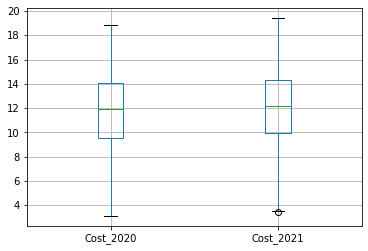

In [8]:
Comparison_Practice_21_22 = Site_Cost[['Cost_2020', 'Cost_2021']].boxplot()

Basic Comments

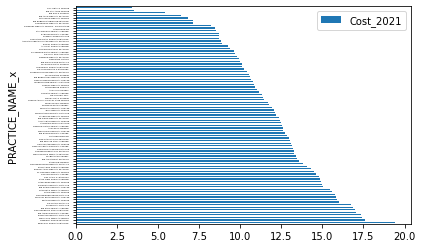

In [9]:
Bar_Site = Site_Cost.plot(kind = 'barh', y= 'Cost_2021', x='PRACTICE_NAME_x').tick_params(axis= 'y' , labelsize = 2)

In [ ]:
Baic comments

## Sites of Intrest for PHE

Text(0.5, 1.0, 'Top 10 Highest Spending (Per Capita) GP Surgeries')

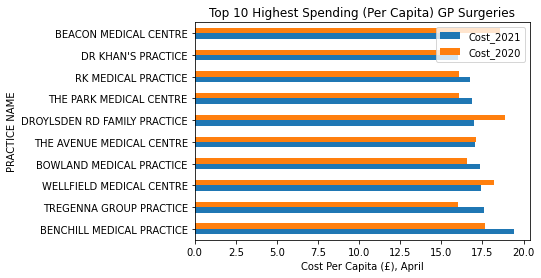

In [10]:
## Top 10

Site_Cost_Top_10 = Site_Cost.nlargest(10, "Cost_2021")

Top_10 = Site_Cost_Top_10[['Cost_2021', 'Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Cost Per Capita (£), April')
plt.title('Top 10 Highest Spending (Per Capita) GP Surgeries')

Comment

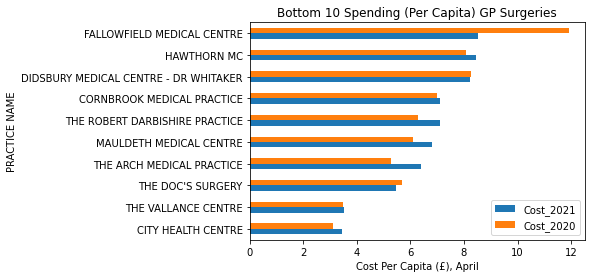

In [11]:
# Bottom 10

Site_Cost_Bottom_10 = Site_Cost.nsmallest(10, "Cost_2021")

Bottom_10 = Site_Cost_Bottom_10[['Cost_2021', 'Cost_2020']].plot.barh()
plt.ylabel('PRACTICE NAME')
plt.xlabel('Cost Per Capita (£), April')
plt.title('Bottom 10 Spending (Per Capita) GP Surgeries')
plt.show()

       Cost_2020  Population_y  Cost_2021  Percentage_Change
count  85.000000     85.000000  85.000000          85.000000
mean   11.850550   7973.470588  12.029193           2.407316
std     3.305455   3942.665356   3.200868           9.367835
min     3.120043   1808.000000   3.437274         -28.543823
25%     9.507459   5292.000000   9.988564          -3.613998
50%    11.956393   7059.000000  12.159857           3.202806
75%    14.089607   9573.000000  14.330138           6.768971
max    18.845562  23425.000000  19.399125          42.611368
                              PRACTICE_CODE POSTCODE  \
PRACTICE_NAME_x                                        
AL-SHIFA MEDICAL CENTRE              P84665  M20 3HE   
THE ARCH MEDICAL PRACTICE            P84630  M15 5TJ   
AILSA CRAIG MEDICAL CENTRE           P84009  M13 0YL   
NEW COLLEGIATE MEDICAL CENTRE        P84030   M8 0DA   
MANCHESTER MEDICAL                   P84616  M14 4GP   

                                             PRACTICE_NAME

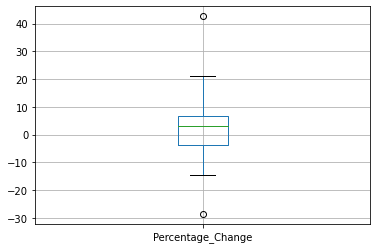

In [12]:
#Change difference

Site_Cost =Site_Cost.sort_values(by = 'Percentage_Change', ascending= False)

Site_Change = Site_Cost.boxplot( column = "Percentage_Change", return_type = 'axes')

print(Site_Cost.describe())

print(Site_Cost.head())

## Regional Data

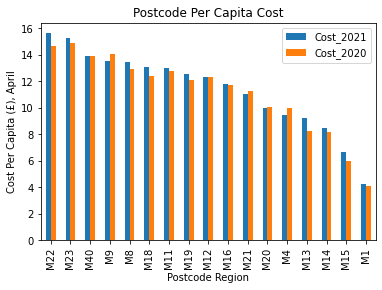

In [13]:
Postcode_Cost =Postcode_Cost.sort_values(by = 'Cost_2021', ascending= False)

Postcode_Cost.set_index("Postcode_Region", drop=False, inplace = True)

Postcode_Bar = Postcode_Cost[['Cost_2021', 'Cost_2020']].plot.bar()
plt.xlabel('Postcode Region')
plt.ylabel('Cost Per Capita (£), April')
plt.title('Postcode Per Capita Cost')
plt.show()

## Maps

In [14]:
Manchester_Map['features'][1]['properties']

Postcode_Cost['id']= Postcode_Cost['Postcode_Region']

Postcode_Dictionary = {}

for feature in Manchester_Map['features']:
    feature['id']=feature['properties']['name']
    Postcode_Dictionary[feature['properties']['name']] =feature['id']
    
fig1 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Cost_2021', hover_name='Postcode_Region', title= "Cost Per Capita April 2021" )
fig1.update_geos(fitbounds = "locations", visible= False)
fig1.show()

fig2 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Cost_2020', hover_name='Postcode_Region', title= "Cost Per Capita April 2020" )
fig2.update_geos(fitbounds = "locations", visible= False)
fig2.show()

fig3 = px.choropleth(Postcode_Cost, locations = 'id', geojson= Manchester_Map, color= 'Percentage_Change', hover_name='Postcode_Region', title= "Percentage Change in cost" )
fig3.update_geos(fitbounds = "locations", visible= False)
fig3.show()